[1,   100] loss: 0.443
[1,   200] loss: 0.423
[1,   300] loss: 0.421
[1,   400] loss: 0.445
[1,   500] loss: 0.445
[1,   600] loss: 0.438
[1,   700] loss: 0.413
[1,   800] loss: 0.442
[1,   900] loss: 0.453
[2,   100] loss: 0.408
[2,   200] loss: 0.442
[2,   300] loss: 0.430
[2,   400] loss: 0.423
[2,   500] loss: 0.426
[2,   600] loss: 0.440
[2,   700] loss: 0.427
[2,   800] loss: 0.434
[2,   900] loss: 0.411
[3,   100] loss: 0.445
[3,   200] loss: 0.449
[3,   300] loss: 0.429
[3,   400] loss: 0.447
[3,   500] loss: 0.452
[3,   600] loss: 0.399
[3,   700] loss: 0.426
[3,   800] loss: 0.430
[3,   900] loss: 0.411
[4,   100] loss: 0.436
[4,   200] loss: 0.424
[4,   300] loss: 0.445
[4,   400] loss: 0.428
[4,   500] loss: 0.440
[4,   600] loss: 0.421
[4,   700] loss: 0.411
[4,   800] loss: 0.434
[4,   900] loss: 0.420
[5,   100] loss: 0.394
[5,   200] loss: 0.425
[5,   300] loss: 0.422
[5,   400] loss: 0.421
[5,   500] loss: 0.436
[5,   600] loss: 0.421
[5,   700] loss: 0.433
[5,   800] 

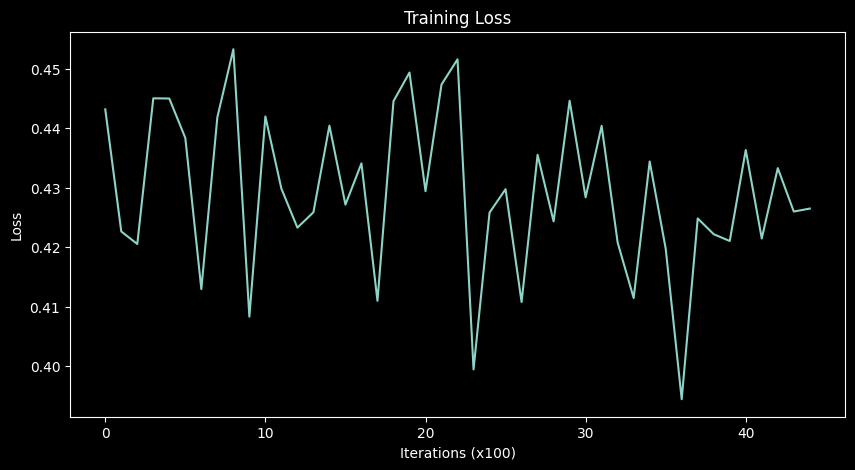

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define the Siamese Network
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        self.fc = nn.Sequential(
            nn.Linear(256 * 3 * 3, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 2)
        )

    def forward_one(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        return output1, output2

# Contrastive loss function
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = nn.functional.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)

# Initialize the network and loss
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = SiameseNetwork().to(device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0005)

def train(epochs):
    losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        for i, (data, labels) in enumerate(train_loader, 0):
            # Move data to device
            data = data.to(device)
            labels = labels.to(device)

            # Create pairs of images
            batch_size = data.size(0)
            perm = torch.randperm(batch_size)
            img0 = data
            img1 = data[perm]
            
            # Create labels: 1 if same class, 0 if different
            label = (labels == labels[perm]).float()

            # print(f"Batch shape: {img0.shape}")  # Debug print

            optimizer.zero_grad()

            # Debug prints
            # print("Forward pass for img0:")
            # x = net.conv(img0)
            # print(f"After conv: {x.shape}")
            # x = x.view(x.size(0), -1)
            # print(f"After flatten: {x.shape}")
            # x = net.fc(x)
            # print(f"After fc: {x.shape}")

            output1, output2 = net(img0, img1)
            # print(f"Output shapes: {output1.shape}, {output2.shape}")  # Debug print

            loss = criterion(output1, output2, label)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 100 == 99:
                losses.append(running_loss / 100)
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
                running_loss = 0.0

        #     if i == 0:  # Only run one batch for debugging
        #         break
        # break  # Only run one epoch for debugging
    return losses

# Train the network
losses = train(5)  # Run for just one epoch

# Plot the loss curve
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Iterations (x100)')
plt.ylabel('Loss')
plt.show()

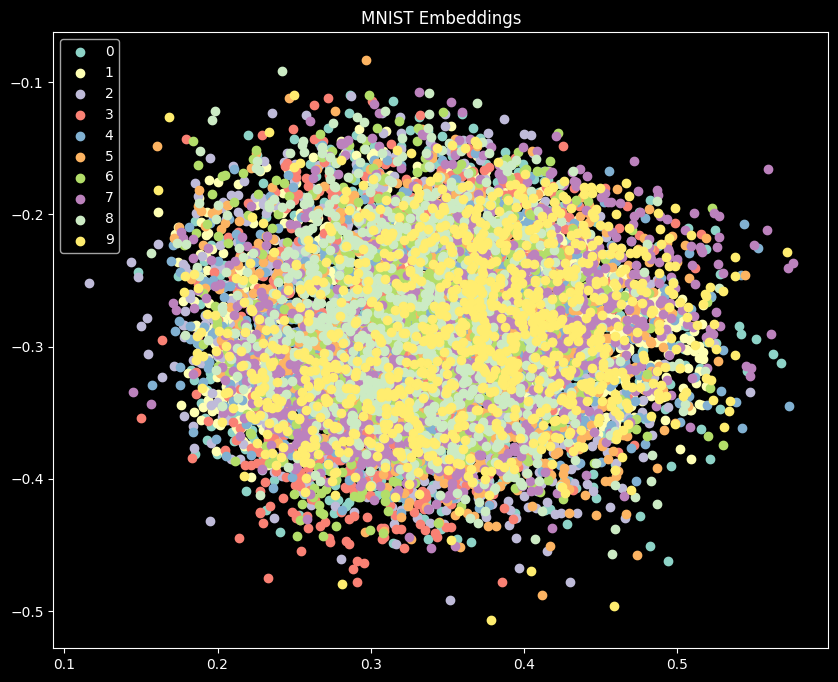

Network architecture:
SiameseNetwork(
  (conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=2304, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=2, bias=True)
  )


In [12]:
BATCH_SIZE = 64

# Visualize learned embeddings
def visualize_embeddings():
    net.eval()
    test_loader = DataLoader(datasets.MNIST(root='./data', train=False, download=True, transform=transform), 
                             batch_size=BATCH_SIZE, shuffle=False)
    all_embeddings = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            embeddings = net.forward_one(images)
            all_embeddings.append(embeddings.cpu().numpy())
            all_labels.append(labels.numpy())

    all_embeddings = np.concatenate(all_embeddings)
    all_labels = np.concatenate(all_labels)

    plt.figure(figsize=(10, 8))
    for i in range(10):
        plt.scatter(all_embeddings[all_labels == i, 0], all_embeddings[all_labels == i, 1], label=str(i))
    plt.legend()
    plt.title('MNIST Embeddings')
    plt.show()

visualize_embeddings()

# Error checking
print(f"Network architecture:")
print(net)
print(f"\nDevice: {device}")
print(f"Batch size: {BATCH_SIZE}")

